Importing in the required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision.models import ResNet50_Weights
from tqdm import tqdm
import torch.nn.functional as F
import os

Loading in the MNIST dataset and preprocessing it

In [7]:
mnist_transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert to 3 channels for ResNet-50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=mnist_transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=mnist_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Setting the device

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


ResNet 50 model

In [8]:
class BaseModel(nn.Module):
    def __init__(self,
                n_class : int = 31):
        super(BaseModel, self).__init__()
        self.n_class = n_class
        self.model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        n_features = self.model.fc.in_features
        fc = torch.nn.Linear(n_features, n_class)
        self.model.fc = fc
        self.model.fc.weight.data.normal_(0, 0.005)
        self.model.fc.bias.data.fill_(0.1)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

# Testing the Base
num_classes = 10
test_model = BaseModel(n_class=num_classes)

test_model.to(device)

summary(test_model, input_size=(64,3,224,224))


Layer (type:depth-idx)                        Output Shape              Param #
BaseModel                                     [64, 10]                  --
├─ResNet: 1-1                                 [64, 10]                  --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        128
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 256, 56, 56]         --
│    │    └─Bottleneck: 3-1                   [64, 256, 56, 56]         75,008
│    │    └─Bottleneck: 3-2                   [64, 256, 56, 56]         70,400
│    │    └─Bottleneck: 3-3                   [64, 256, 56, 56]         70,400
│    └─Sequential: 2-6                        [64, 512, 28, 28]         --
│    │    └─Bottleneck: 3-4                   [64, 512, 28, 28]         379,392

Checking the Feature Extractor being loaded in

In [2]:
from models.network import ResNetFeatureExtractor, ResNetClassifier

model_g = ResNetFeatureExtractor(pretrained=True)

# Forward pass with the feature extractor
x = torch.randn(64, 3, 224, 224)
x = model_g(x)
print(x.shape)

# Checking the feature extractor summary using torchinfo
summary(model_g, input_size=(64,3,224,224))

model_c = ResNetClassifier(num_classes=31, input_size=2048, temp=0.05)

# Forward pass with the classifier using the output x from the feature extractor
c = model_c(x)
print(c.shape)

# Checking the classifier summary using torchinfo
summary(model_c, input_size=(64,2048))

torch.Size([64, 2048])
torch.Size([64, 31])


Layer (type:depth-idx)                   Output Shape              Param #
ResNetClassifier                         [64, 31]                  --
├─Linear: 1-1                            [64, 31]                  63,488
Total params: 63,488
Trainable params: 63,488
Non-trainable params: 0
Total mult-adds (M): 4.06
Input size (MB): 0.52
Forward/backward pass size (MB): 0.02
Params size (MB): 0.25
Estimated Total Size (MB): 0.79

Loading in Modnet from SFUDA

In [15]:
from models.sfuda_net import modnet
from config import config_supervised

num_C = config_supervised.settings['num_C']
num_Cs_dash = config_supervised.settings['num_Cs_dash']
num_Ct_dash = config_supervised.settings['num_Ct_dash']
num_Cs = config_supervised.settings['num_Cs']
num_Ct = config_supervised.settings['num_Ct']

sfuda_model = modnet(num_C=num_C, num_Cs_dash=num_Cs_dash, num_Ct_dash=num_Ct_dash, cnn='resnet50')

# Forward pass with the SFUDA model
# x = torch.randn(64, 3, 224, 224)
# x = sfuda_model(x)
# print(x.shape)

# Checking the SFUDA model summary using torchinfo
# summary(sfuda_model, input_size=(64,3,224,224))

In [16]:
# Entropy Calculation Function
def calculate_entropy(logits):
    """
    Calculates entropy from logits.
    Entropy = -Σ(p(x) * log(p(x)))
    """
    probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
    log_probabilities = F.log_softmax(logits, dim=1)
    entropy = -torch.sum(probabilities * log_probabilities, dim=1)  # Entropy for each sample
    return entropy

# # Training Function
# def train_model(model, dataloader, optimizer, criterion, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     for images, labels in tqdm(dataloader, desc="Training", leave=False):
#         images, labels = images.to(device), labels.to(device)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Metrics
#         total_loss += loss.item()
#         _, preds = torch.max(outputs, dim=1)
#         correct += (preds == labels).sum().item()
#         total_samples += labels.size(0)

#     avg_loss = total_loss / len(dataloader)
#     accuracy = correct / total_samples * 100
#     return avg_loss, accuracy

# # Validation Function with Entropy Evaluation
# def validate_model_with_entropy(model, dataloader, criterion, device, entropy_threshold=0.5):
#     """
#     Evaluates the model and calculates accuracy for low-entropy and high-entropy samples.
    
#     Args:
#         model: PyTorch model.
#         dataloader: DataLoader for validation/test data.
#         criterion: Loss function.
#         device: 'cuda' or 'cpu'.
#         entropy_threshold: Threshold to separate low-entropy and high-entropy samples.

#     Returns:
#         avg_loss: Average loss over all validation data.
#         accuracy: Overall accuracy.
#         low_entropy_accuracy: Accuracy for low-entropy samples.
#         high_entropy_accuracy: Accuracy for high-entropy samples.
#         low_entropy_count: Total number of low-entropy samples.
#         high_entropy_count: Total number of high-entropy samples.
#     """
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_samples = 0

#     # Low and high entropy tracking
#     low_entropy_correct = 0
#     low_entropy_total = 0
#     high_entropy_correct = 0
#     high_entropy_total = 0

#     with torch.no_grad():
#         for images, labels in tqdm(dataloader, desc="Validating", leave=False):
#             images, labels = images.to(device), labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Entropy calculation
#             entropy = calculate_entropy(outputs)
#             low_entropy_mask = entropy < entropy_threshold
#             high_entropy_mask = entropy >= entropy_threshold

#             # Metrics for all samples
#             total_loss += loss.item()
#             _, preds = torch.max(outputs, dim=1)
#             correct += (preds == labels).sum().item()
#             total_samples += labels.size(0)

#             # Metrics for low-entropy samples
#             if low_entropy_mask.sum() > 0:
#                 low_entropy_preds = preds[low_entropy_mask]
#                 low_entropy_labels = labels[low_entropy_mask]
#                 low_entropy_correct += (low_entropy_preds == low_entropy_labels).sum().item()
#                 low_entropy_total += low_entropy_labels.size(0)

#             # Metrics for high-entropy samples
#             if high_entropy_mask.sum() > 0:
#                 high_entropy_preds = preds[high_entropy_mask]
#                 high_entropy_labels = labels[high_entropy_mask]
#                 high_entropy_correct += (high_entropy_preds == high_entropy_labels).sum().item()
#                 high_entropy_total += high_entropy_labels.size(0)

#     # Calculate metrics
#     avg_loss = total_loss / len(dataloader)
#     accuracy = correct / total_samples * 100
#     low_entropy_accuracy = (low_entropy_correct / low_entropy_total * 100) if low_entropy_total > 0 else 0
#     high_entropy_accuracy = (high_entropy_correct / high_entropy_total * 100) if high_entropy_total > 0 else 0

#     return avg_loss, accuracy, low_entropy_accuracy, high_entropy_accuracy, low_entropy_total, high_entropy_total

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        images = batch['image'].to(device)   # Access 'image' key
        labels = batch['label'].to(device)   # Access 'label' key

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples * 100
    return avg_loss, accuracy

def validate_model_with_entropy(model, dataloader, criterion, device, entropy_threshold=0.5):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    low_entropy_correct = 0
    low_entropy_total = 0
    high_entropy_correct = 0
    high_entropy_total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            images = batch['image'].to(device)  # Access 'image' key
            labels = batch['label'].to(device)  # Access 'label' key

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Entropy calculation
            entropy = calculate_entropy(outputs)
            low_entropy_mask = entropy < entropy_threshold
            high_entropy_mask = entropy >= entropy_threshold

            # Metrics for all samples
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Metrics for low-entropy samples
            if low_entropy_mask.sum() > 0:
                low_entropy_preds = preds[low_entropy_mask]
                low_entropy_labels = labels[low_entropy_mask]
                low_entropy_correct += (low_entropy_preds == low_entropy_labels).sum().item()
                low_entropy_total += low_entropy_labels.size(0)

            # Metrics for high-entropy samples
            if high_entropy_mask.sum() > 0:
                high_entropy_preds = preds[high_entropy_mask]
                high_entropy_labels = labels[high_entropy_mask]
                high_entropy_correct += (high_entropy_preds == high_entropy_labels).sum().item()
                high_entropy_total += high_entropy_labels.size(0)

    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples * 100
    low_entropy_accuracy = (low_entropy_correct / low_entropy_total * 100) if low_entropy_total > 0 else 0
    high_entropy_accuracy = (high_entropy_correct / high_entropy_total * 100) if high_entropy_total > 0 else 0

    return avg_loss, accuracy, low_entropy_accuracy, high_entropy_accuracy, low_entropy_total, high_entropy_total


# Fine-tuning Function
def finetune_model_with_entropy(model, train_loader, val_loader, optimizer, criterion, device, epochs=5, entropy_threshold=0.5):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # Training step
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion, device)
        
        # Validation step
        val_loss, val_acc, low_entropy_acc, high_entropy_acc, low_entropy_count, high_entropy_count = validate_model_with_entropy(
            model, val_loader, criterion, device, entropy_threshold
        )

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")
        print(f"Low-Entropy Sample Accuracy: {low_entropy_acc:.2f}% | Samples: {low_entropy_count}")
        print(f"High-Entropy Sample Accuracy: {high_entropy_acc:.2f}% | Samples: {high_entropy_count}\n")

    return model

In [17]:
model = BaseModel(n_class=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

# alpha = 0.5
# beta = 0.5

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, train_loader, test_loader, optimizer, criterion, device, epochs, entropy_threshold
)

NameError: name 'train_loader' is not defined

Office-31 Dataset

In [23]:
data_path = 'OFFICE31'
amazon_path = os.path.join(data_path, 'amazon')
webcam_path = os.path.join(data_path, 'webcam')
dslr_path = os.path.join(data_path, 'dslr')

print('amazon_path:', amazon_path)
print('webcam_path:', webcam_path)
print('dslr_path:', dslr_path)

def load_data(root_path, domain, batch_size, phase):
    transform_dict = {
        'src': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
        'tar': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ])}
    data = datasets.ImageFolder(root=os.path.join(root_path, domain), transform=transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=phase=='src', drop_last=phase=='tar', num_workers=4)
    return data_loader

amazon_loader = load_data(data_path, 'amazon', 64, 'src')
webcam_loader = load_data(data_path, 'webcam', 64, 'tar')
dslr_loader = load_data(data_path, 'dslr', 64, 'tar')

# Checking the size of these data loaders
print('amazon_loader size:', len(amazon_loader))
print('webcam_loader size:', len(webcam_loader))
print('dslr_loader size:', len(dslr_loader))


amazon_path: OFFICE31/amazon
webcam_path: OFFICE31/webcam
dslr_path: OFFICE31/dslr
amazon_loader size: 45
webcam_loader size: 12
dslr_loader size: 7


Loading in OFFICE-31 dataloders

In [3]:
from dataset.data_loader import Office31Dataset

data_path = 'usfda_office_31_DtoA'

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
source_train_dataset = Office31Dataset(root_dir=data_path, split='train', domain='source', transform=transform)
target_train_dataset = Office31Dataset(root_dir=data_path, split='train', domain='target', transform=transform)
source_val_dataset = Office31Dataset(root_dir=data_path, split='val', domain='source', transform=transform)
target_val_dataset = Office31Dataset(root_dir=data_path, split='val', domain='target', transform=transform)

# Create DataLoaders
source_train_loader = DataLoader(source_train_dataset, batch_size=64, shuffle=True)
target_train_loader = DataLoader(target_train_dataset, batch_size=64, shuffle=True)
source_val_loader = DataLoader(source_val_dataset, batch_size=64, shuffle=False)
target_val_loader = DataLoader(target_val_dataset, batch_size=64, shuffle=False)

# Checking the size of these data loaders
print('source_train_loader size:', len(source_train_loader))
print('target_train_loader size:', len(target_train_loader))
print('source_val_loader size:', len(source_val_loader))
print('target_val_loader size:', len(target_val_loader))

# Checking the number of classes in the source and target datasets
print('Number of classes in the source dataset:', source_train_dataset.get_num_classes())
print('Number of classes in the target dataset:', target_train_dataset.get_num_classes())


# Test the DataLoader
for batch in source_train_loader:
    images = batch['image']   # Shape: (32, 3, 224, 224)
    labels = batch['label']   # Shape: (32,)
    filenames = batch['filename']
    print(f"Batch Image Shape: {images.shape}")
    print(f"Labels Shape: {labels.shape}")
    print(f"Labels: {labels}")
    break

Loaded 3500 images from usfda_office_31_DtoA/source_images/train
Number of classes: 20
Loaded 21966 images from usfda_office_31_DtoA/target_images/train
Number of classes: 21
Loaded 73 images from usfda_office_31_DtoA/source_images/val
Number of classes: 20
Loaded 398 images from usfda_office_31_DtoA/target_images/val
Number of classes: 21
source_train_loader size: 55
target_train_loader size: 344
source_val_loader size: 2
target_val_loader size: 7
Number of classes in the source dataset: 20
Number of classes in the target dataset: 21
Batch Image Shape: torch.Size([64, 3, 224, 224])
Labels Shape: torch.Size([64])
Labels: tensor([11,  6,  7, 18,  5,  9,  9,  6, 17,  3, 18, 11, 13, 17,  3, 13, 10, 14,
         8,  5,  1, 19, 10,  8, 12,  4, 17, 15,  1,  0,  7, 17, 12, 18, 11, 18,
        15,  6,  3, 12, 10, 11,  3, 17,  3,  3, 18,  4, 16, 10, 12,  3,  6, 18,
        16, 11, 10, 14,  9,  7,  3,  4, 18, 18])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


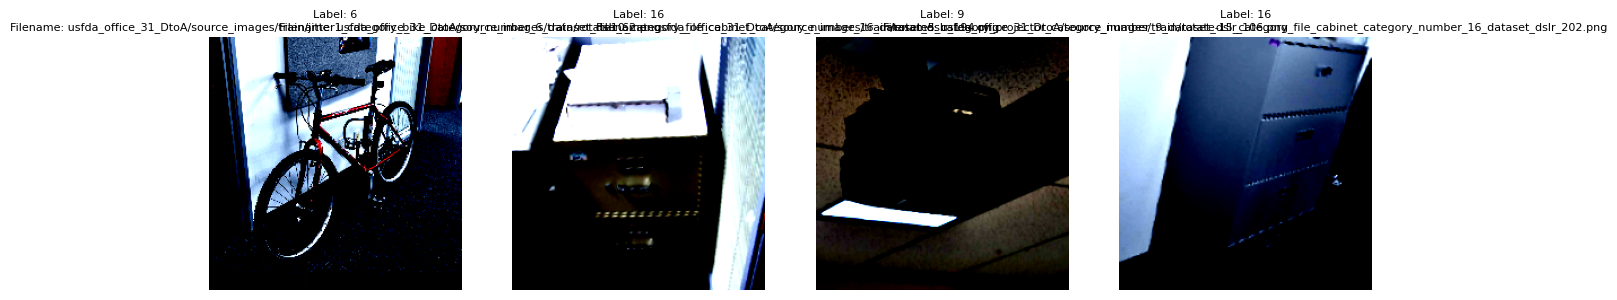

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


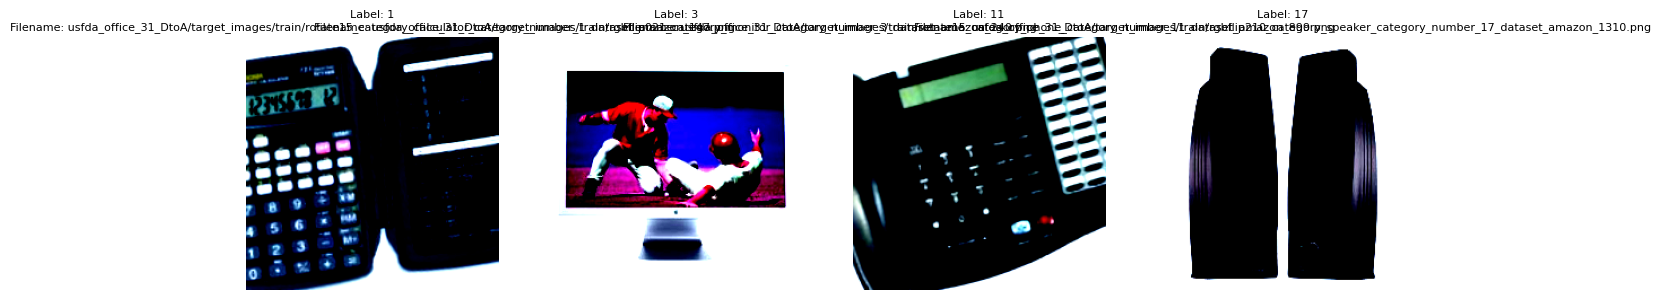

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


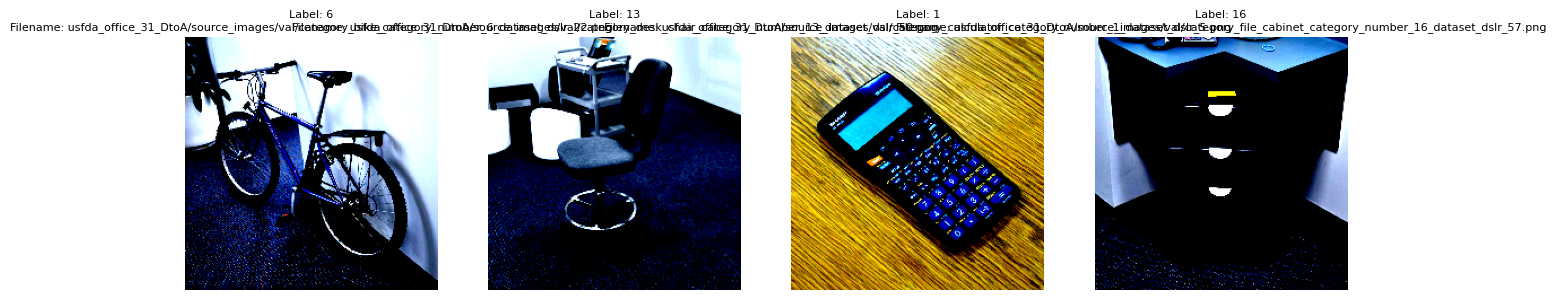

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


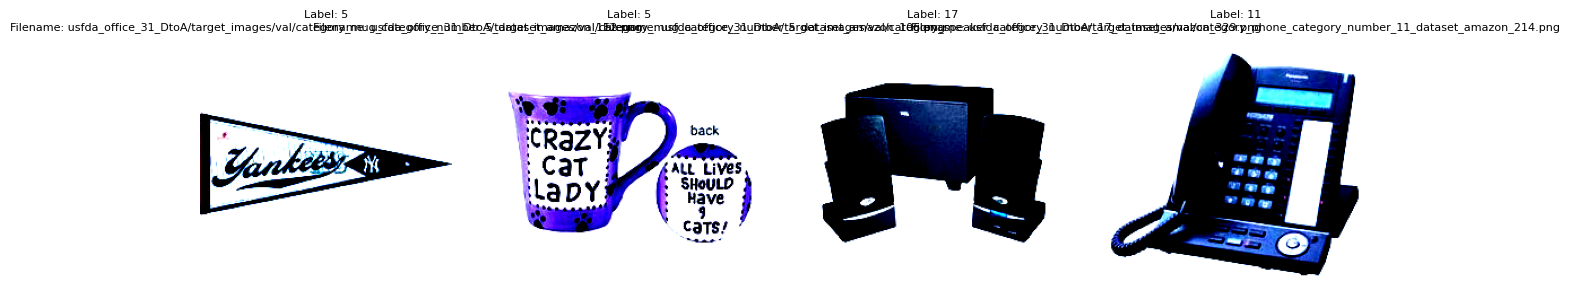

In [4]:
# Checking a few images from each of the dataloaders
def show_images_grid(dataloader, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, batch in enumerate(dataloader):
        images = batch['image']
        labels = batch['label']
        filenames = batch['filename']
        for j in range(num_images):
            image = images[j].permute(1, 2, 0).numpy()
            label = labels[j].item()
            filename = filenames[j]
            axes[j].imshow(image)
            axes[j].set_title(f"Label: {label}\nFilename: {filename}", fontsize=8)
            axes[j].axis('off')
        break
    plt.show()

# Show images from the source train loader
show_images_grid(source_train_loader)
show_images_grid(target_train_loader)
show_images_grid(source_val_loader)
show_images_grid(target_val_loader)

Checking the negative dataset

In [8]:
from dataset.negative_dataloader import NegativeDataset
from glob import glob

# Paths to negative dataset
negative_data_path = "./negative_images"

# Fetch all negative dataset file paths
negative_file_paths = glob(os.path.join(negative_data_path, "*.png"))
print(f"Number of negative samples: {len(negative_file_paths)}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize NegativeDataset
negative_dataset = NegativeDataset(file_paths=negative_file_paths, transform=transform)

# Create DataLoader
negative_dataloader = DataLoader(negative_dataset, batch_size=64, shuffle=True)

# Checking one batch of negative samples
for batch in negative_dataloader:
    images = batch['image']
    label = batch['label']
    filenames = batch['filename']
    print(f"Batch Image Shape: {images.shape}")
    print(f"Label: {label}")
    print(f"Filenames: {filenames}")
    print(len(filenames))
    break


Number of negative samples: 20000
Batch Image Shape: torch.Size([64, 3, 224, 224])
Label: tensor([ 29, 175, 122,  95, 121,  79, 119,  35, 183, 129, 122,  95, 159, 153,
         60,  61, 153, 133, 129, 101, 119, 143, 112,  48,  59,  47, 122, 146,
        103, 135, 152, 112, 170,  94,  64, 113,  81, 121, 106, 133, 122, 112,
        139, 160, 101, 126,  13,  25, 139, 159, 152, 168, 110, 140, 174, 110,
        105,  13, 111,  41, 135, 112, 129,  72])
Filenames: ['./negative_images/category_29_category_number_29_dataset_dslr_5353.png', './negative_images/category_175_category_number_175_dataset_dslr_18722.png', './negative_images/category_122_category_number_122_dataset_dslr_385.png', './negative_images/category_95_category_number_95_dataset_dslr_4419.png', './negative_images/category_121_category_number_121_dataset_dslr_10619.png', './negative_images/category_79_category_number_79_dataset_dslr_19319.png', './negative_images/category_119_category_number_119_dataset_dslr_2850.png', './negati

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


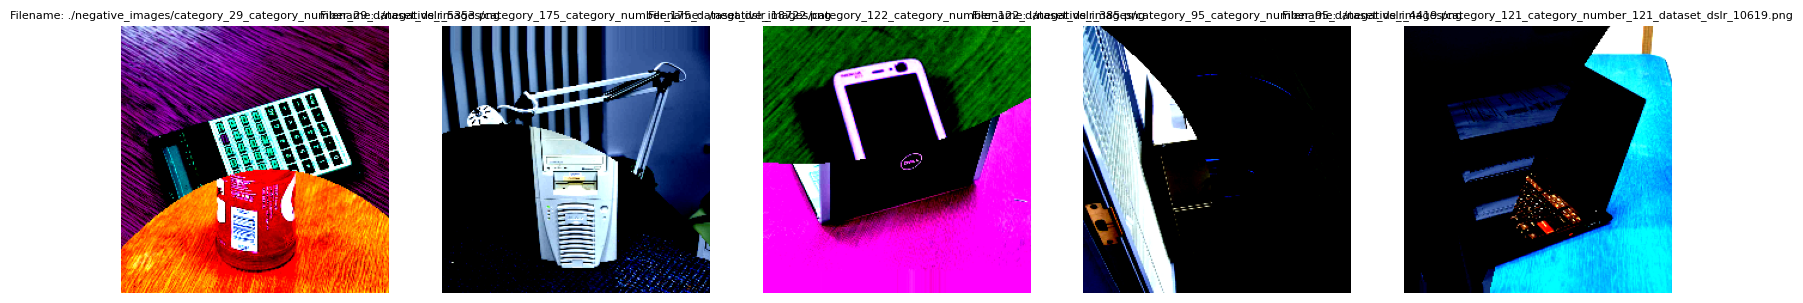

In [9]:
# Visualizing five negative samples from the first batch
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image = images[i].permute(1, 2, 0).numpy()
    filename = filenames[i]
    axes[i].imshow(image)
    axes[i].set_title(f"Filename: {filename}", fontsize=8)
    axes[i].axis('off')
plt.show()

In [19]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

# amazon_dataloader = load_data(data_path, 'amazon', 64, 'src')
# webcam_dataloader = load_data(data_path, 'webcam', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, source_train_loader, target_val_loader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 0.4119 | Train Accuracy: 90.97%
Val Loss: 3.9939 | Val Accuracy: 22.86%
Low-Entropy Sample Accuracy: 45.78% | Samples: 83
High-Entropy Sample Accuracy: 16.83% | Samples: 315

Epoch 2/5


Train Loss: 0.0743 | Train Accuracy: 98.06%
Val Loss: 5.6084 | Val Accuracy: 9.55%
Low-Entropy Sample Accuracy: 13.29% | Samples: 158
High-Entropy Sample Accuracy: 7.08% | Samples: 240

Epoch 3/5


KeyboardInterrupt: 

Office-31 experiments

A -> W

In [31]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

amazon_dataloader = load_data(data_path, 'amazon', 64, 'src')
webcam_dataloader = load_data(data_path, 'webcam', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, amazon_dataloader, webcam_dataloader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 1.9858 | Train Accuracy: 48.28%
Val Loss: 3.3646 | Val Accuracy: 22.01%
Low-Entropy Sample Accuracy: 36.84% | Samples: 95
High-Entropy Sample Accuracy: 19.91% | Samples: 673

Epoch 2/5


Train Loss: 1.3434 | Train Accuracy: 64.54%
Val Loss: 2.7813 | Val Accuracy: 24.35%
Low-Entropy Sample Accuracy: 77.14% | Samples: 35
High-Entropy Sample Accuracy: 21.83% | Samples: 733

Epoch 3/5


Train Loss: 1.2127 | Train Accuracy: 68.09%
Val Loss: 3.0010 | Val Accuracy: 26.69%
Low-Entropy Sample Accuracy: 89.66% | Samples: 29
High-Entropy Sample Accuracy: 24.22% | Samples: 739

Epoch 4/5


Train Loss: 1.0146 | Train Accuracy: 73.66%
Val Loss: 2.6660 | Val Accuracy: 32.55%
Low-Entropy Sample Accuracy: 73.81% | Samples: 42
High-Entropy Sample Accuracy: 30.17% | Samples: 726

Epoch 5/5


Train Loss: 0.9049 | Train Accuracy: 75.93%
Val Loss: 2.9777 | Val Accuracy: 25.52%
Low-Entropy Sample Accuracy: 84.00% | Samples: 50
High-Entropy Sample Accuracy: 21.45% | Samples: 718



A -> D

In [32]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

amazon_dataloader = load_data(data_path, 'amazon', 64, 'src')
dslr_dataloader = load_data(data_path, 'dslr', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, amazon_dataloader, dslr_dataloader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 2.0550 | Train Accuracy: 46.22%
Val Loss: 2.3619 | Val Accuracy: 37.28%
Low-Entropy Sample Accuracy: 75.00% | Samples: 56
High-Entropy Sample Accuracy: 31.89% | Samples: 392

Epoch 2/5


Train Loss: 1.3697 | Train Accuracy: 65.50%
Val Loss: 2.4366 | Val Accuracy: 39.29%
Low-Entropy Sample Accuracy: 68.57% | Samples: 70
High-Entropy Sample Accuracy: 33.86% | Samples: 378

Epoch 3/5


Train Loss: 1.1047 | Train Accuracy: 69.44%
Val Loss: 2.6677 | Val Accuracy: 33.04%
Low-Entropy Sample Accuracy: 72.55% | Samples: 51
High-Entropy Sample Accuracy: 27.96% | Samples: 397

Epoch 4/5


Train Loss: 1.0382 | Train Accuracy: 71.35%
Val Loss: 2.3513 | Val Accuracy: 40.40%
Low-Entropy Sample Accuracy: 78.02% | Samples: 91
High-Entropy Sample Accuracy: 30.81% | Samples: 357

Epoch 5/5


Train Loss: 0.9125 | Train Accuracy: 75.97%
Val Loss: 2.7853 | Val Accuracy: 32.37%
Low-Entropy Sample Accuracy: 78.08% | Samples: 73
High-Entropy Sample Accuracy: 23.47% | Samples: 375



W -> A

In [33]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

webcam_dataloader = load_data(data_path, 'webcam', 64, 'src')
amazon_dataloader = load_data(data_path, 'amazon', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, webcam_dataloader, amazon_dataloader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 2.3140 | Train Accuracy: 48.30%
Val Loss: 4.4856 | Val Accuracy: 23.69%
Low-Entropy Sample Accuracy: 37.05% | Samples: 691
High-Entropy Sample Accuracy: 19.34% | Samples: 2125

Epoch 2/5


Train Loss: 0.7477 | Train Accuracy: 80.50%
Val Loss: 4.5420 | Val Accuracy: 18.68%
Low-Entropy Sample Accuracy: 29.47% | Samples: 587
High-Entropy Sample Accuracy: 15.84% | Samples: 2229

Epoch 3/5


Train Loss: 0.5360 | Train Accuracy: 84.91%
Val Loss: 3.4547 | Val Accuracy: 27.66%
Low-Entropy Sample Accuracy: 51.32% | Samples: 569
High-Entropy Sample Accuracy: 21.67% | Samples: 2247

Epoch 4/5


Train Loss: 0.5190 | Train Accuracy: 85.53%
Val Loss: 2.9769 | Val Accuracy: 29.55%
Low-Entropy Sample Accuracy: 76.03% | Samples: 292
High-Entropy Sample Accuracy: 24.17% | Samples: 2524

Epoch 5/5


Train Loss: 0.3927 | Train Accuracy: 89.06%
Val Loss: 3.7211 | Val Accuracy: 25.28%
Low-Entropy Sample Accuracy: 42.93% | Samples: 580
High-Entropy Sample Accuracy: 20.71% | Samples: 2236



W -> D

In [34]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

webcam_dataloader = load_data(data_path, 'webcam', 64, 'src')
dslr_dataloader = load_data(data_path, 'dslr', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, webcam_dataloader, dslr_dataloader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 2.2908 | Train Accuracy: 45.16%
Val Loss: 1.9336 | Val Accuracy: 58.04%
Low-Entropy Sample Accuracy: 71.64% | Samples: 201
High-Entropy Sample Accuracy: 46.96% | Samples: 247

Epoch 2/5


Train Loss: 0.8020 | Train Accuracy: 78.74%
Val Loss: 0.8835 | Val Accuracy: 72.54%
Low-Entropy Sample Accuracy: 90.27% | Samples: 226
High-Entropy Sample Accuracy: 54.50% | Samples: 222

Epoch 3/5


Train Loss: 0.5637 | Train Accuracy: 84.78%
Val Loss: 1.0540 | Val Accuracy: 70.76%
Low-Entropy Sample Accuracy: 90.62% | Samples: 224
High-Entropy Sample Accuracy: 50.89% | Samples: 224

Epoch 4/5


Train Loss: 0.4006 | Train Accuracy: 89.31%
Val Loss: 0.7178 | Val Accuracy: 80.13%
Low-Entropy Sample Accuracy: 96.88% | Samples: 224
High-Entropy Sample Accuracy: 63.39% | Samples: 224

Epoch 5/5


Train Loss: 0.3804 | Train Accuracy: 89.18%
Val Loss: 0.6548 | Val Accuracy: 80.13%
Low-Entropy Sample Accuracy: 94.58% | Samples: 240
High-Entropy Sample Accuracy: 63.46% | Samples: 208



D -> A

In [35]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

dslr_dataloader = load_data(data_path, 'dslr', 64, 'src')
amazon_dataloader = load_data(data_path, 'amazon', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, dslr_dataloader, amazon_dataloader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 2.7258 | Train Accuracy: 35.54%
Val Loss: 14.9562 | Val Accuracy: 4.01%
Low-Entropy Sample Accuracy: 7.69% | Samples: 13
High-Entropy Sample Accuracy: 4.00% | Samples: 2803

Epoch 2/5


Train Loss: 0.9414 | Train Accuracy: 78.11%
Val Loss: 12.0211 | Val Accuracy: 7.21%
Low-Entropy Sample Accuracy: 11.25% | Samples: 471
High-Entropy Sample Accuracy: 6.40% | Samples: 2345

Epoch 3/5


Train Loss: 0.4157 | Train Accuracy: 87.15%
Val Loss: 3.8529 | Val Accuracy: 28.27%
Low-Entropy Sample Accuracy: 39.20% | Samples: 574
High-Entropy Sample Accuracy: 25.47% | Samples: 2242

Epoch 4/5


Train Loss: 0.3259 | Train Accuracy: 90.36%
Val Loss: 46.0419 | Val Accuracy: 3.91%
Low-Entropy Sample Accuracy: 3.75% | Samples: 2720
High-Entropy Sample Accuracy: 8.33% | Samples: 96

Epoch 5/5


Train Loss: 0.3055 | Train Accuracy: 92.97%
Val Loss: 37.3888 | Val Accuracy: 4.30%
Low-Entropy Sample Accuracy: 4.91% | Samples: 2015
High-Entropy Sample Accuracy: 2.75% | Samples: 801



D -> W

In [36]:
model = BaseModel(n_class=31).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5
entropy_threshold = 0.5  # Set the threshold for low-entropy samples

dslr_dataloader = load_data(data_path, 'dslr', 64, 'src')
webcam_dataloader = load_data(data_path, 'webcam', 64, 'tar')

# Fine-tune the model and evaluate entropy
trained_model = finetune_model_with_entropy(
    model, dslr_dataloader, webcam_dataloader, optimizer, criterion, device, epochs, entropy_threshold
)

Epoch 1/5


Train Loss: 2.6948 | Train Accuracy: 38.35%
Val Loss: 3.5691 | Val Accuracy: 35.55%
Low-Entropy Sample Accuracy: 68.25% | Samples: 211
High-Entropy Sample Accuracy: 23.16% | Samples: 557

Epoch 2/5


Train Loss: 1.0607 | Train Accuracy: 78.11%
Val Loss: 1.6099 | Val Accuracy: 55.73%
Low-Entropy Sample Accuracy: 78.55% | Samples: 275
High-Entropy Sample Accuracy: 43.00% | Samples: 493

Epoch 3/5


Train Loss: 0.4581 | Train Accuracy: 87.75%
Val Loss: 1.1796 | Val Accuracy: 67.19%
Low-Entropy Sample Accuracy: 88.00% | Samples: 300
High-Entropy Sample Accuracy: 53.85% | Samples: 468

Epoch 4/5


Train Loss: 0.2722 | Train Accuracy: 93.17%
Val Loss: 1.7352 | Val Accuracy: 52.86%
Low-Entropy Sample Accuracy: 86.27% | Samples: 153
High-Entropy Sample Accuracy: 44.55% | Samples: 615

Epoch 5/5


Train Loss: 0.3821 | Train Accuracy: 90.16%
Val Loss: 1.8397 | Val Accuracy: 55.60%
Low-Entropy Sample Accuracy: 81.01% | Samples: 258
High-Entropy Sample Accuracy: 42.75% | Samples: 510

